In [1]:
from configparser import ConfigParser, ExtendedInterpolation
from functools import reduce
from itertools import product


import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from spikelib.utils import check_directory, datasets_to_array

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

idx =  pd.IndexSlice
# %matplotlib notebook 

In [2]:
exp_name = config['EXP']['name']
sync_file = config['FILES']['sync']
source_file = config['FILES']['processed']
suffix= '_' + config['PROCESSED']['suffix']
output_folder = '../../reports/fig/flash/'
check_directory(output_folder)
print('SOURCE FILE: ' + source_file)

protocol = 'flash'
nd_filters = ['nd3',]
intensities = [50, 100, 150, 200, 255]
extra = ['cyan']
nintensities = len(intensities)


SOURCE FILE: /home/vnc/Documents/Alzheimer/Degus/MR-0061/data/processed_protocols/MR-0061_oldcircus_analysis_of_protocols.hdf5


# Load Data

* Columns = intensities
* Rows = latency, peak_response, sustained index, bias_idx

In [3]:
df_list = []
with h5py.File(source_file)  as panalysis:
    for nd, intensity, kextra in product(nd_filters, intensities, extra):
        fields = dict(protocol=protocol, nd=nd, extra=kextra, intensity=intensity)
        base_group = '/{protocol}/{nd}/{intensity:03d}_{extra}/'.format(**fields)
        flash_charg = base_group + 'char/'
        flash_typeg = base_group + 'type/'

        col_name = [k.strip() for k in panalysis[flash_charg].attrs['col_name'].split(',')]
        char_array, keys = datasets_to_array(panalysis[flash_charg])
        type_array, type_keys = datasets_to_array(panalysis[flash_typeg])
        columns = pd.MultiIndex.from_product([[nd], [intensity], extra, col_name], names=['nd', 'intensity', 'extra', 'char'])
        df = pd.DataFrame(data=char_array, index=keys, columns=columns)
        df[(nd, intensity, kextra, 'type')] = pd.Series(type_array, index=type_keys)
        df_list.append(df)
char_data = reduce(lambda x, y: x.join(y, how='outer'), df_list)

In [4]:
char_data.columns.levels

FrozenList([['nd3'], [50, 100, 150, 200, 255], ['cyan'], ['bias_idx', 'decay_off', 'decay_on', 'frmax_off', 'frmax_on', 'latency_off', 'latency_on', 'resp_index_off', 'resp_index_on', 'sust_index_off', 'sust_index_on', 'type']])

# General Plots
## heatmap

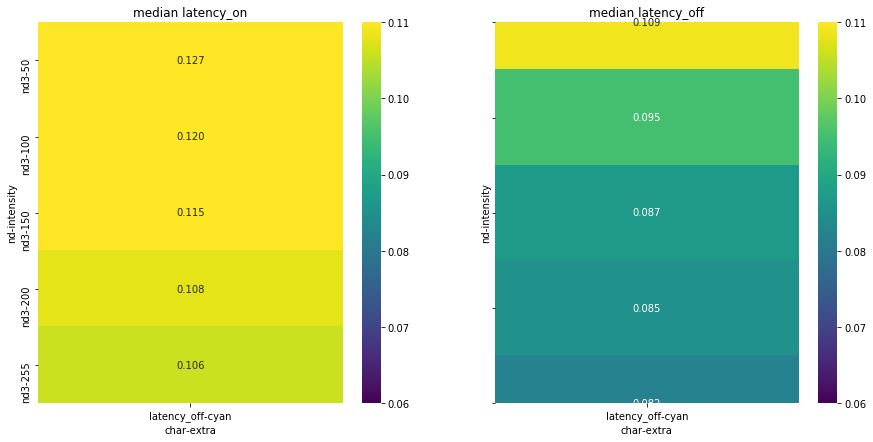

In [5]:
output_file = '{path}{exp}_colormap_latencies_{suffix}.png'.format(
    path=output_folder, exp=exp_name, suffix=suffix)

cm_kws = dict(vmin=0.06, vmax=0.11, annot=True, cmap='viridis', fmt='.3f',)
f, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True, sharex=True)
latency_on = char_data.loc[:, idx[:, :, :, ['latency_on']]].replace(0, None).round(3).median().unstack().unstack()
sns.heatmap(data=latency_on, ax=ax[0], **cm_kws)
latency_off = char_data.loc[:, idx[:, :, :, ['latency_off']]].replace(0, None).round(3).median().unstack().unstack()
sns.heatmap(data=latency_off, ax=ax[1], **cm_kws)
ax[0].set(title='median latency_on')
ax[1].set(title='median latency_off')
f.savefig(output_file)

## Boxesplot 

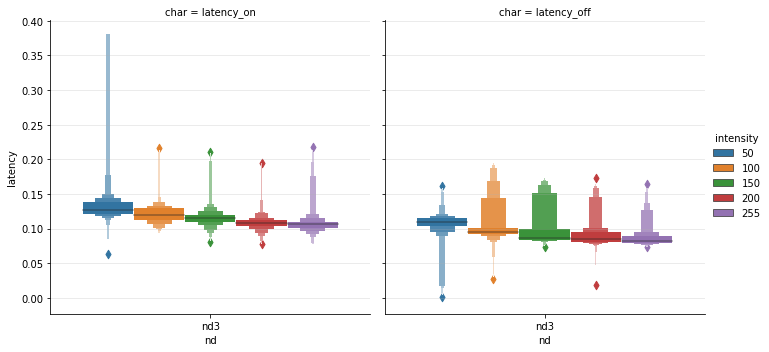

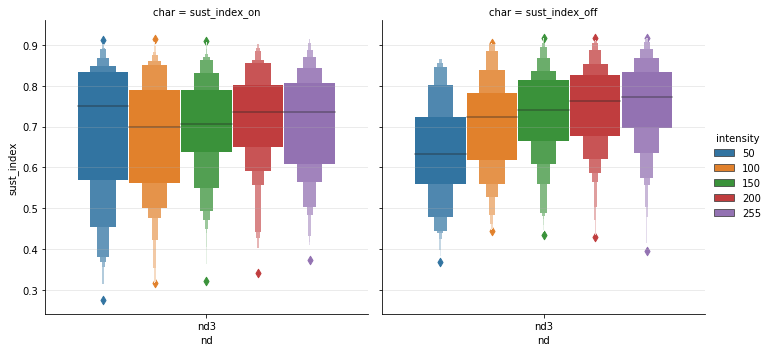

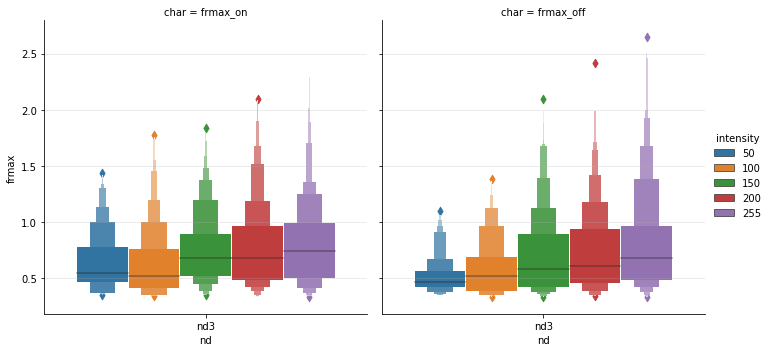

In [6]:
col_names = [['latency_on', 'latency_off'], ['sust_index_on', 'sust_index_off'],
             ['frmax_on', 'frmax_off',] ]
for col_name in col_names:
    output_file = '{path}{exp}_boxenplot_{feature}{suffix}.png'.format(
        path=output_folder, exp=exp_name, feature='_'.join(col_name), suffix=suffix)
    features = char_data.loc[:, idx[:, :, :, col_name]].replace(0, None).unstack().reset_index()
    name = col_name[0][:-3]
    features.rename(columns={0: name}, inplace=True)
    g = sns.catplot(x='nd', y=name, hue='intensity', kind='boxen', col='char', 
                    data=features, sharey=True, )
    [*map(lambda x: x.grid(True, alpha=0.3, axis='y'), g.axes.flatten())];
    g.savefig(output_file)

# Relation between On and Off features

/home/vnc/anaconda3/envs/spkdev/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vnc/anaconda3/envs/spkdev/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


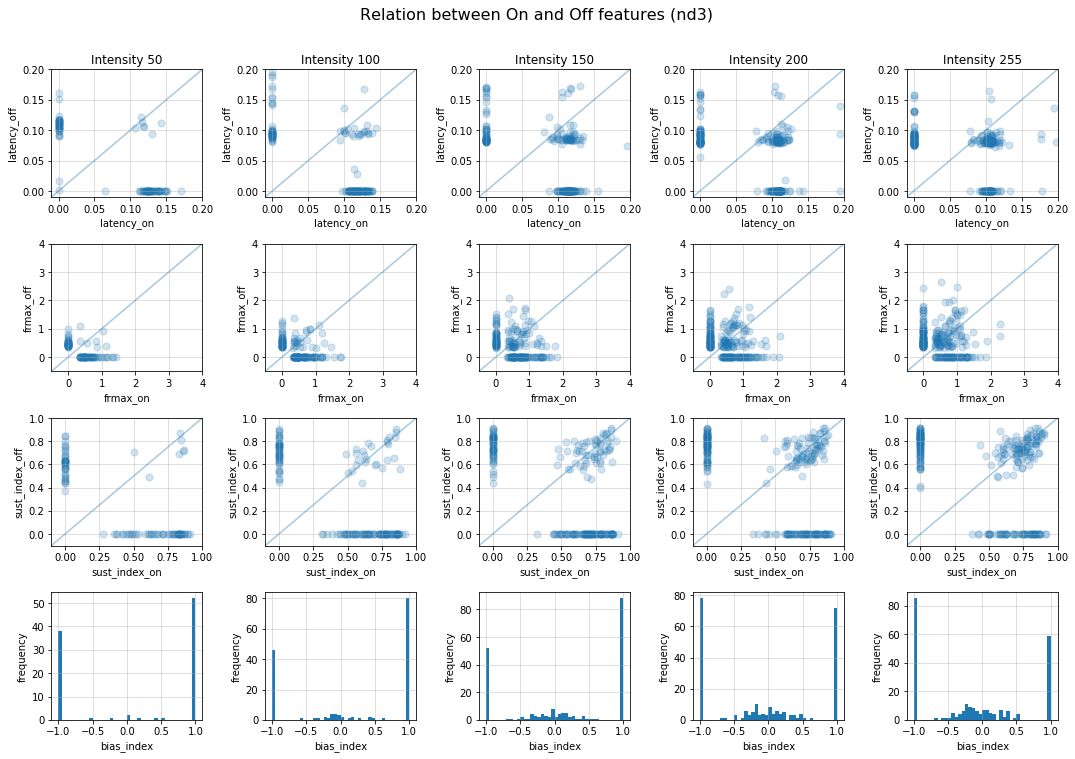

In [7]:
kwargs_scatter = dict(alpha=0.2, s=50)
for nd_filter in nd_filters:
    output_file = '{path}{exp}_{prefix}_relation_On-Off_features{suffix}'.format(
        path=output_folder, exp=exp_name, prefix=nd_filter, suffix=suffix)
    fig, ax = plt.subplots(
        nrows=4,
        ncols= nintensities,
        figsize=(3*nintensities,2*nintensities),
        sharex=False,
        sharey=False,
    )
    for kidx, (kintensity, kextra) in enumerate(product(intensities, extra)):
        ax[0, kidx].scatter(
            x=char_data.loc[:, (nd_filter, kintensity, kextra, 'latency_on')].values,
            y=char_data.loc[:, (nd_filter, kintensity, kextra, 'latency_off')].values,
            **kwargs_scatter,
        )
        ax[1, kidx].scatter(
            x=char_data.loc[:, (nd_filter, kintensity, kextra, 'frmax_on')].values,
            y=char_data.loc[:, (nd_filter, kintensity, kextra, 'frmax_off')].values,
            **kwargs_scatter,
        )
        ax[2, kidx].scatter(
            x=char_data.loc[:, (nd_filter, kintensity, kextra, 'sust_index_on')].values,
            y=char_data.loc[:, (nd_filter, kintensity, kextra, 'sust_index_off')].values,
            **kwargs_scatter,
        )
        ax[3,kidx].hist(
            char_data.loc[:, (nd_filter, kintensity, kextra, 'bias_idx')].values,
            bins=40,
            range=(-1,1)
        )
        latency_lim = [-0.01,0.2]
        fr_lim = [-0.5,4]
        sust_lim = [-0.1,1]
        ax[0,kidx].plot(latency_lim, latency_lim, alpha = 0.4)
        ax[1,kidx].plot(fr_lim, fr_lim, alpha = 0.4)
        ax[2,kidx].plot(sust_lim, sust_lim, alpha = 0.4)
        ax[0,kidx].set(xlim=latency_lim, ylim=latency_lim, xlabel='latency_on',
                       ylabel='latency_off', title='Intensity {}'.format(kintensity))
        ax[1,kidx].set(xlim=fr_lim, ylim=fr_lim, xlabel='frmax_on', ylabel='frmax_off')
        ax[2,kidx].set(xlim=sust_lim, ylim=sust_lim, xlabel='sust_index_on', 
                       ylabel='sust_index_off')
        ax[3,kidx].set(xlabel='bias_index', ylabel='frequency')

    for kax in ax.flatten():
        kax.grid(alpha=0.5)

    fig.suptitle('Relation between On and Off features ({})'.format(nd_filter),
                 y=1.05, fontsize=16)
    fig.tight_layout()
    fig.savefig(output_file+'.png', bbox_inches='tight')

# Temporal relation between intensities

##  Relationtion between 255 and 200-150-100-50

In [8]:
def plot_flash(ax, x, y , limits, **kwds):
    ax.scatter(x, y, alpha=0.3, s=10, **kwds)
    ax.plot(limits, limits, alpha=0.2, color='r')
    ax.grid(alpha=0.4, ls=':')
    return ax

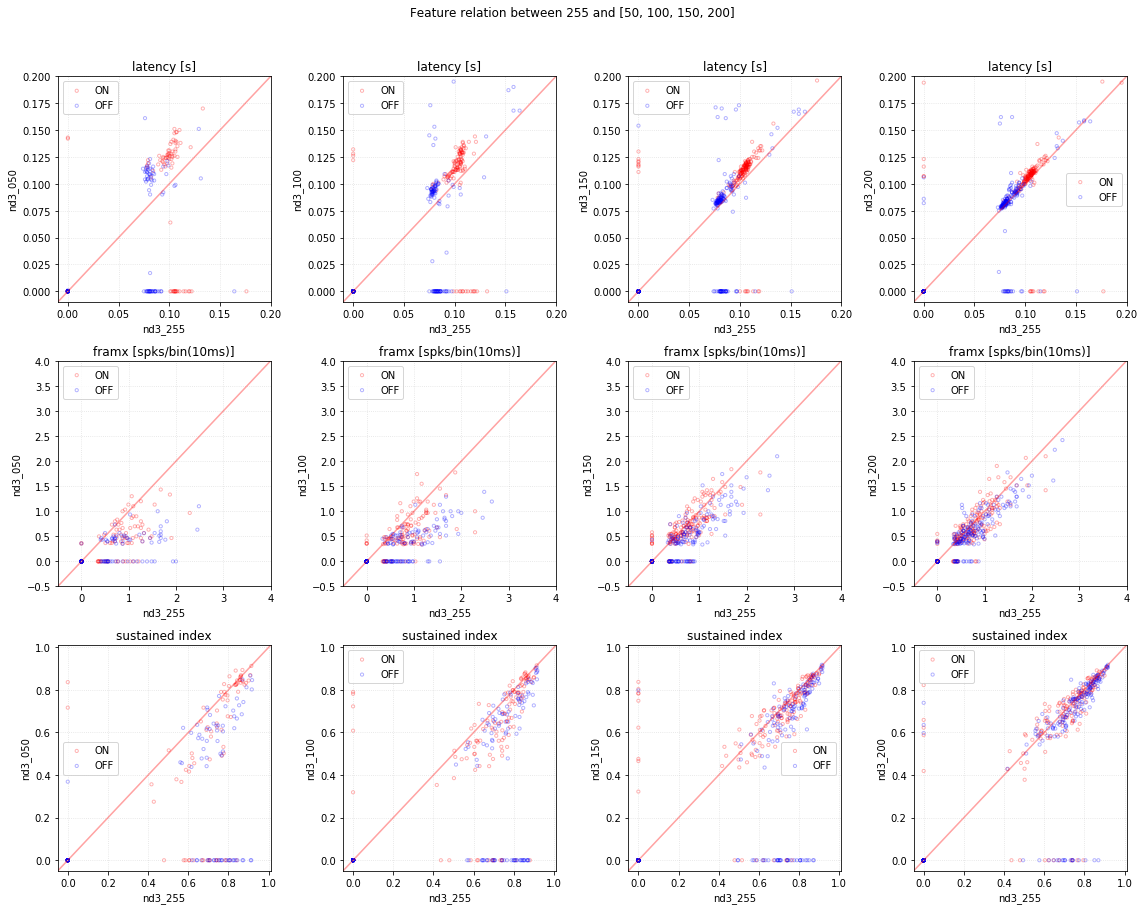

In [9]:
ref_int = 255

for nd_filter in nd_filters:
    output_file = (
        '{path}{exp}_relation_255_vs_200-150-100-50_{prefix}_{suffix}'
    ).format(path=output_folder, exp=exp_name, prefix=nd_filter, suffix=suffix)

    fig, ax = plt.subplots(3, nintensities-1, figsize=(4*(nintensities-1), 4*3))
    kwds_on = {'facecolors': 'None', 'edgecolors': 'r', 'label': 'ON'}
    kwds_off = {'facecolors': 'None', 'edgecolors': 'b', 'label': 'OFF'}

    for kidx, (intensity, kextra) in enumerate(product(intensities[:-1], extra)):
        ylabel = '{}_{:03d}'.format(nd_filter, intensity)
        xlabel = '{}_{:03d}'.format(nd_filter, ref_int)
        field = 'latency_on'
        limits = [-0.01, 0.2]
        kax = plot_flash(ax=ax[0, kidx],
                         x=char_data.loc[:,(nd_filter, ref_int, kextra, field)].values,
                         y=char_data.loc[:,(nd_filter, intensity, kextra, field)].values,
                         limits=limits,
                         **kwds_on)
        field = 'latency_off'
        kax = plot_flash(ax=ax[0, kidx],
                 x=char_data.loc[:,(nd_filter, ref_int, kextra, field)].values,
                 y=char_data.loc[:,(nd_filter, intensity, kextra, field)].values,
                 limits=limits,
                 **kwds_off)
        kax.set(xlim=limits, ylim=limits, xlabel=xlabel, ylabel=ylabel, title='latency [s]')


        field = 'frmax_on'
        limits = [-0.5, 4]
        kax = plot_flash(ax=ax[1, kidx],
                 x=char_data.loc[:,(nd_filter, ref_int, kextra, field)].values,
                 y=char_data.loc[:,(nd_filter, intensity, kextra, field)].values,
                 limits=limits,
                 **kwds_on)
        field = 'frmax_off'
        kax = plot_flash(ax=ax[1, kidx],
                         x=char_data.loc[:,(nd_filter, ref_int, kextra, field)].values,
                         y=char_data.loc[:,(nd_filter, intensity, kextra, field)].values,
                         limits=limits,
                         **kwds_off)        
        kax.set(xlim=limits, ylim=limits, xlabel=xlabel, ylabel=ylabel, title='framx [spks/bin(10ms)]')

        field = 'sust_index_on'
        limits = [-0.05, 1.01]
        kax = plot_flash(ax=ax[2, kidx],
                 x=char_data.loc[:,(nd_filter, ref_int, kextra, field)].values,
                 y=char_data.loc[:,(nd_filter, intensity, kextra, field)].values,
                 limits=limits,
                 **kwds_on)
        field = 'sust_index_off'
        kax = plot_flash(ax=ax[2, kidx],
                         x=char_data.loc[:,(nd_filter, ref_int, kextra, field)].values,
                         y=char_data.loc[:,(nd_filter, intensity, kextra, field)].values,
                         limits=limits,
                         **kwds_off)
        
        kax.set(xlim=limits, ylim=limits, xlabel=xlabel, ylabel=ylabel, title='sustained index')
        
    for kax in ax.flatten():
        kax.legend()
    fig.suptitle('Feature relation between {} and {}'.format(ref_int, intensities[:-1]), y=1.05)
    plt.tight_layout()
    # fig.savefig(output_file+'_on-off.pdf', bbox_inches='tight')
    fig.savefig(output_file+'.png', bbox_inches='tight')
plt.show()

## Histograms

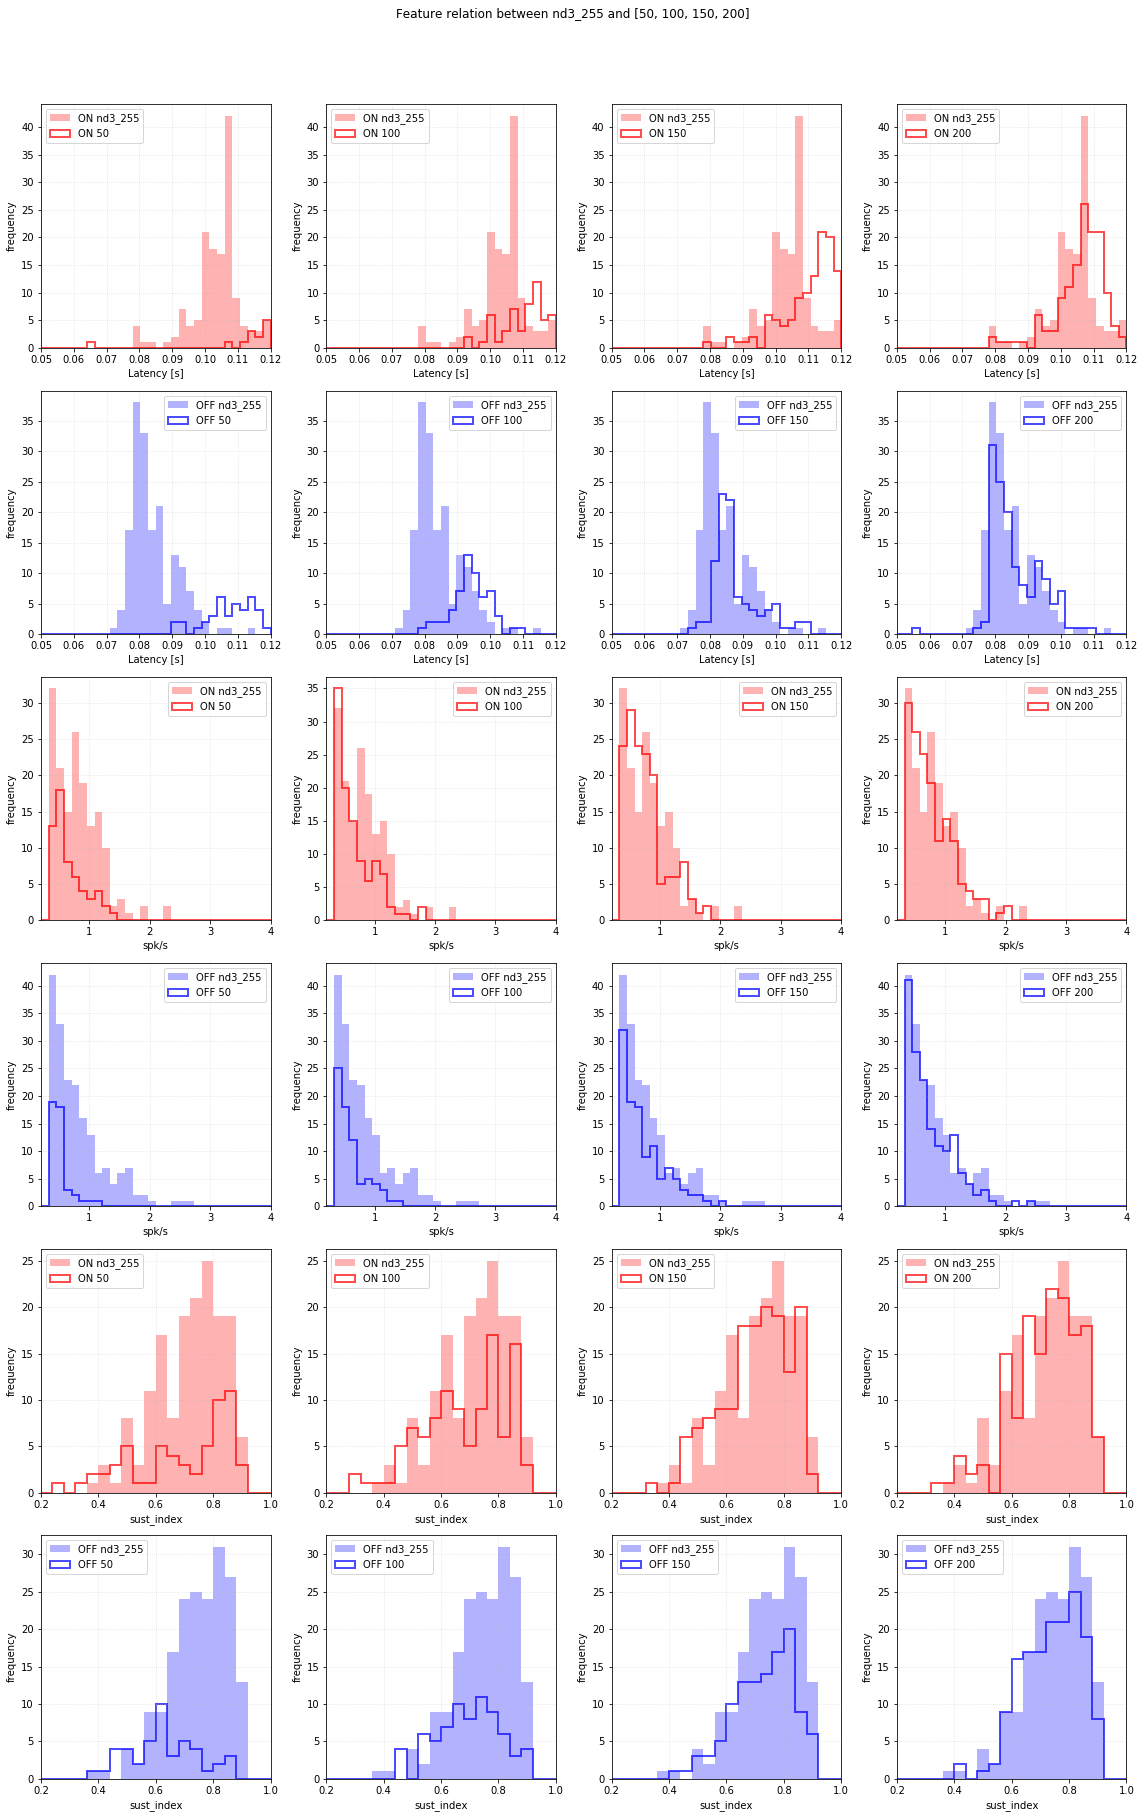

In [10]:
ref_int = 255

for nd_filter in nd_filters:
    output_file = (
        '{path}{exp}_histograms_255_vs_200-150-100-50_{prefix}_{suffix}'
    ).format(path=output_folder, exp=exp_name, prefix=nd_filter, suffix=suffix)
    contrast = '{}_{:03d}'.format(nd_filter, ref_int)
    intensities_ = intensities[:-1]
    nintensities_ = len(intensities_)
    

    fig, ax = plt.subplots(6, nintensities_, figsize=(4*len(intensities_), 4*6))
    for kidx, (kintensity, kextra) in enumerate(product(intensities_, extra)):
        kwargs = {
            0: {'alpha':0.3, 'color':'red', 'lw':2, 'ls':'-', 
                'label':'ON {}'.format(contrast), 'histtype': 'bar', },
            1: {'alpha':0.7, 'color':'red', 'lw':2, 'ls':'-',
                'label':'ON {}'.format(kintensity), 'histtype': 'step', },
            2: {'alpha':0.3, 'color':'blue', 'lw':2, 'ls':'-',
                'label':'OFF {}'.format(contrast), 'histtype': 'bar', },
            3: {'alpha':0.7, 'color':'blue', 'lw':2, 'ls':'-',
                'label':'OFF {}'.format(kintensity), 'histtype': 'step',},
        }
        
        field = 'latency_on'
        limits = [0.05, 0.12]
        kwargs = {key: {**values, 'bins':30, 'range':tuple(limits)} for key, values in kwargs.items()}
        ax[0, kidx].hist(char_data.loc[:,(nd_filter, ref_int, kextra, field)].values, **kwargs[0])
        ax[0, kidx].hist(char_data.loc[:,(nd_filter, kintensity, kextra, field)].values, **kwargs[1])
        ax[0, kidx].set(xlim=limits, xlabel='Latency [s]', ylabel='frequency', )
        ax[0, kidx].legend()
        field = 'latency_off'
        ax[1, kidx].hist(char_data.loc[:,(nd_filter, ref_int, kextra, field)].dropna().values, **kwargs[2])
        ax[1, kidx].hist(char_data.loc[:,(nd_filter, kintensity, kextra, field)].dropna().values, **kwargs[3])
        ax[1, kidx].set(xlim=limits, xlabel='Latency [s]', ylabel='frequency', )
        ax[1, kidx].legend()
        
        field = 'frmax_on'
        limits = [0.2, 4]
        kwargs = {key: {**values, 'bins':30, 'range':tuple(limits)} for key, values in kwargs.items()}
        ax[2, kidx].hist(char_data.loc[:,(nd_filter, ref_int, kextra, field)].values, **kwargs[0])
        ax[2, kidx].hist(char_data.loc[:,(nd_filter, kintensity, kextra, field)].values, **kwargs[1])
        ax[2, kidx].set(xlim=limits, xlabel='spk/s', ylabel='frequency', )
        ax[2, kidx].legend()
        field = 'frmax_off'
        ax[3, kidx].hist(char_data.loc[:,(nd_filter, ref_int, kextra, field)].dropna().values, **kwargs[2])
        ax[3, kidx].hist(char_data.loc[:,(nd_filter, kintensity, kextra, field)].dropna().values, **kwargs[3])
        ax[3, kidx].set(xlim=limits, xlabel='spk/s', ylabel='frequency', )
        ax[3, kidx].legend()

        field = 'sust_index_on'
        limits = [0.2, 1.0]
        kwargs = {key: {**values, 'bins':20, 'range':tuple(limits)} for key, values in kwargs.items()}
        ax[4, kidx].hist(char_data.loc[:,(nd_filter, ref_int, kextra, field)].values, **kwargs[0])
        ax[4, kidx].hist(char_data.loc[:,(nd_filter, kintensity, kextra, field)].values, **kwargs[1])
        ax[4, kidx].set(xlim=limits, xlabel='sust_index', ylabel='frequency', )
        ax[4, kidx].legend()
        field = 'sust_index_off'
        ax[5, kidx].hist(char_data.loc[:,(nd_filter, ref_int, kextra, field)].dropna().values, **kwargs[2])
        ax[5, kidx].hist(char_data.loc[:,(nd_filter, kintensity, kextra, field)].dropna().values, **kwargs[3])
        ax[5, kidx].set(xlim=limits, xlabel='sust_index', ylabel='frequency', )
        ax[5, kidx].legend()
        
    for kax in ax.flatten():
        kax.grid(alpha=0.4, ls=':')
    fig.suptitle('Feature relation between {} and {}'.format(contrast, intensities_), y=1.05)
    plt.tight_layout()
    fig.savefig(output_file+'_{}.png'.format(suffix), bbox_inches='tight')
plt.show()

### Ralationship between filters nd

# Plot Flash response for different classification
* Columns = intensities
* Rows = Null, On, Off, On-Off

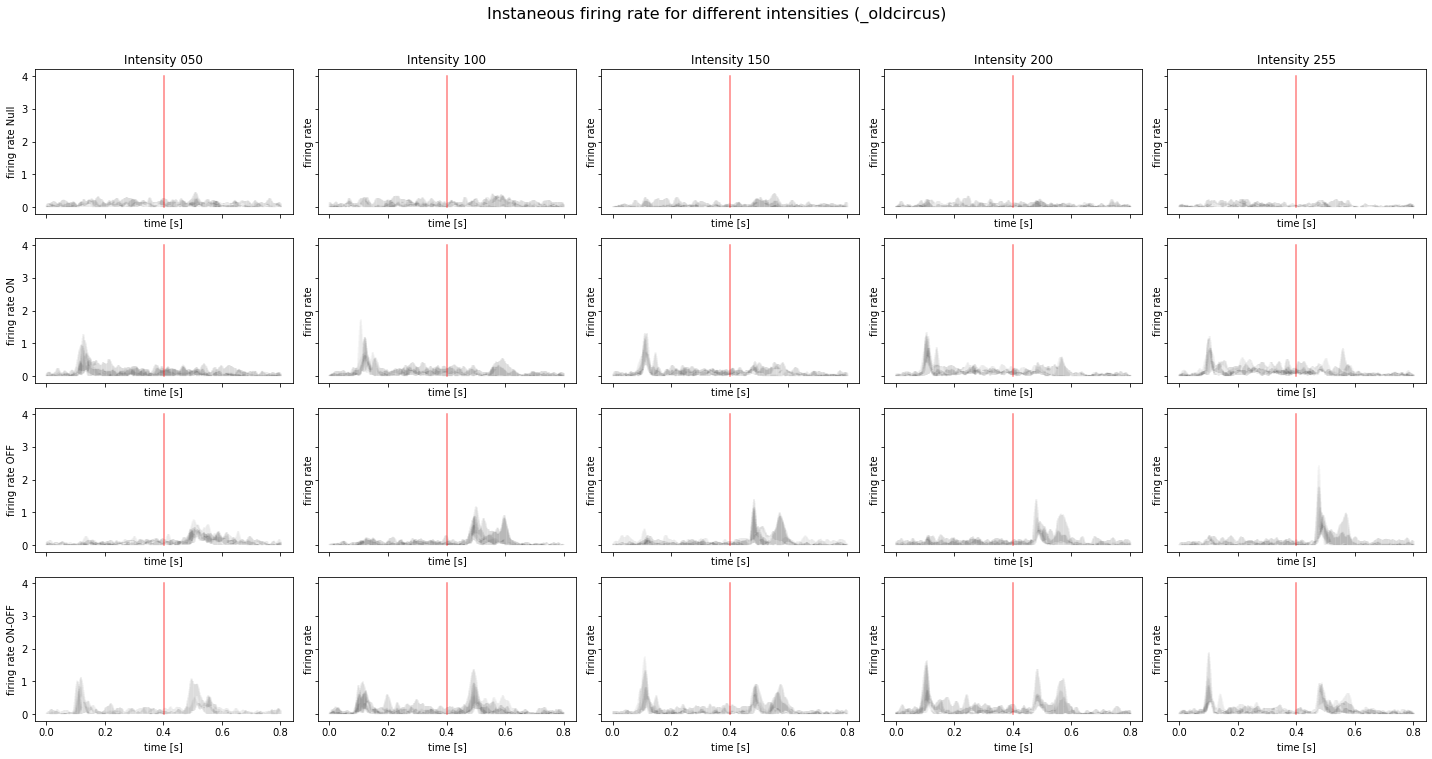

In [11]:
nd = nd_filters[0]
kextra = extra[0]
output_file = '{path}{exp}_{prefix}_response_{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=nd, suffix=suffix)
nd_filter = nd_filters[0]
fig, ax = plt.subplots(4, nintensities, figsize=(4*nintensities,2*nintensities),
                       sharex=True, sharey=True)

def plot_response(ax, base_group, panalysis):
    flash_estfrg = base_group + 'est_psth/'
    flash_typeg = base_group + 'type/'
    
    flash_type, key_type = datasets_to_array(panalysis[flash_typeg])
    estfr, key_estfr = datasets_to_array(panalysis[flash_estfrg])
    start_on, end_on, start_off, end_off = panalysis[flash_estfrg].attrs['bounds']
    time_response = panalysis[flash_estfrg].attrs['time']
    flash_type = flash_type.flatten().astype('int')
    for ktype in [0, 1, 2, 3]:
        sub_response = estfr[flash_type == ktype]
        times = (time_response*np.ones((sub_response.shape[0],1)))
        ax[ktype].plot(times[:10:], sub_response[:10:], alpha=0.1, color='k', lw=0.2)
    return ax

for kint_idx, intensity in enumerate(intensities):
    fields = dict(protocol=protocol, nd=nd, extra=kextra, intensity=intensity)
    base_group = '/{protocol}/{nd}/{intensity:03d}_{extra}/'.format(**fields)
    flash_estfrg = base_group + 'est_psth/'
    flash_typeg = base_group + 'type/'

    with h5py.File(source_file)  as panalysis:
        plot_response(ax[:, kint_idx], base_group, panalysis)
        start_on, end_on, start_off, end_off = panalysis[flash_estfrg].attrs['bounds']
#         flash_type, key_type = datasets_to_array(panalysis[flash_typeg])
#         estfr, key_estfr = datasets_to_array(panalysis[flash_estfrg])
#         start_on, end_on, start_off, end_off = panalysis[flash_estfrg].attrs['bounds']
#         time_response = panalysis[flash_estfrg].attrs['time']
    
#     for (resp, ftype) in zip(estfr, flash_type.flatten().astype('int')):
#         ax[ftype][kint_idx].plot(time_response, resp, alpha=0.3, color='k', lw=0.2)
#     flash_type = flash_type.flatten().astype('int')
#     for ktype in [0, 1, 2, 3]:
#         sub_response = estfr[flash_type == ktype]
#         times = (time_response*np.ones((sub_response.shape[0],1)))
#         ax[ftype][kint_idx].plot(times, sub_response, alpha=0.3, color='k', lw=0.2)
        
        
for kax in ax.flatten():
    kax.set(xlabel='time [s]', ylabel='firing rate')
    ymin, ymax = (0,4)
    kax.plot([start_off, start_off], [ymin, ymax], c='r', alpha=0.5)
for kax, kname in zip(ax[0], intensities):
    kax.set(title='Intensity {:03d}'.format(kname))
for kax, kname in zip(ax[:,0], ['Null', 'ON', 'OFF', 'ON-OFF']):
    label = kax.get_ylabel()
    kax.set(ylabel='{} {}'.format(label, kname))

fig.suptitle('Instaneous firing rate for different intensities ({})'.format(suffix), y=1.05, fontsize=16)

plt.tight_layout()
plt.savefig(output_file+'.png', bbox_inches='tight')
# plt.savefig(output_file+'.pdf', bbox_inches='tight')

In [12]:
plt.close('all')